<a href="https://colab.research.google.com/github/kimdesok/FinanceDataReader/blob/master/COVID_Stock_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid data and its relation to the price and returns of an example stock....

##1. Setting libraries and environment
> * importing libraries for data manipulation, graphics, trend indicator calculation, etc
> * Downloading stock data and preparing them for the further processing

In [1]:
import urllib
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from urllib.request import urlopen
import seaborn as sns


In [2]:
!pip install finance-datareader

#Ta-Lib library installation for calculating trend indicators

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

import talib
import datetime

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3757    0  3757    0     0  20530      0 --:--:-- --:--:-- --:--:-- 20642
100  503k  100  503k    0     0   617k      0 --:--:-- --:--:-- --:--:-- 4786k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3765    0  3765    0     0  10575      0 --:--:-- --:--:-- --:--:-- 10575
100  406k  100  406k    0     0   412k      0 --:--:-- --:--:-- --:--:-- 1516k



### Downloading the stock data

In [3]:
!wget https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv

--2022-01-31 04:06:05--  https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv [following]
--2022-01-31 04:06:05--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44868288 (43M) [text/plain]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv 100%[===================>]  42.79M  70.6MB/s    in 0.6s    

2022-01-31 04:06:06 (70.6 MB/s) - ‘owid-covid-data.csv’ saved [448

2020-01-23 00:00:00
Displaying the data from  2021-12-11 00:00:00 to  2022-01-29 00:00:00 



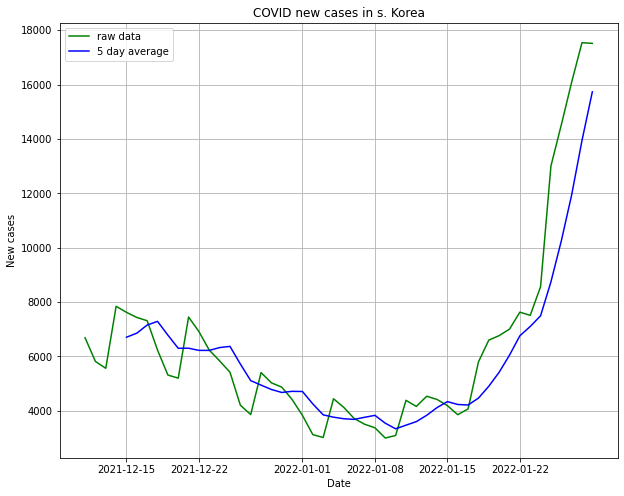

            new_cases
Date                 
2022-01-25    13004.0
2022-01-26    14514.0
2022-01-27    16085.0
2022-01-28    17540.0
2022-01-29    17515.0


In [14]:
import FinanceDataReader as fdr
from datetime import date


my_file = '/content/owid-covid-data.csv'
short_df = pd.read_csv(my_file)
#print(short_df.columns)

short_df = short_df[short_df['location']=='South Korea']

columns=['date', 'new_cases']
short_df= short_df[columns]


# sort the short sell data
short_df['Date'] = pd.to_datetime(short_df['date'])
short_df = short_df.pivot_table(index='Date', values=['new_cases'])
#short_df = short_df.sort_index()

#Set the beginning date for the analysis
print(short_df.index[0])
start_date = short_df.index[0]
end_date = short_df.index[-1] 

#end_date = date.today()

print('Displaying the data from ', short_df.index[-50], 'to ', end_date, '\n')

plt.figure(figsize = (10,8))

#days = [short_df.index[-50], end_date]+[i for i in range(short_df.index[-45],short_df.index[-5])]
#idx = np.asarray([i for i in range(len(days))])
#plt.xticks(idx)
#plt.xticklabels(days, rotation=65)

plt.plot(short_df['new_cases'][-50:], color = 'green', label='raw data')
plt.plot(short_df['new_cases'][-50:].rolling(5).mean(), color = 'blue', label='5 day average')
plt.xlabel('Date')
plt.ylabel('New cases')
plt.title('COVID new cases in s. Korea')
plt.legend()
plt.grid(True)
plt.show()  # show the plot

#plt.clf()  # clear the plot space


#print(short_df.head())
print(short_df.tail())

In [11]:
from numpy.core.numeric import ComplexWarning
# get stock codes from the company names
def get_codes(df, names):
  code_list = {}
  for name in names:
    code = df.query("names=='{}'".format(name))['codes'].to_string(index=False)
    code = code.strip()
    code_list[name] = code
  return code_list

my_file = '/content/drive/MyDrive/datasets/stock_codes.csv'
try:
  with open(my_file, 'r') as f:
    code_df = pd.read_csv(f)
    #print(type(code_df))
except:
  print("Make sure to mount the drive!")


#For this exercise, we need dataframes representing the stock perfromance of many companies.
Company_names = {'SK바이오사이언스':'SK Bioscience', '씨젠':'Seegene', '피씨엘':'PCL', '프레스티지바이오파마':'Prestige Biopharma', \
              '삼성전자':'Samsung','셀트리온':'Celltrion', '현대차':'Hyundai Automobile', \
              '대한항공':'Korean Air', '호텔신라':'Hotel Shilla' }
#Company_names = {'SK바이오사이언스':'SK Bioscience'}

code_list = get_codes(code_df, Company_names)
#print(code_list)

stock_list = {}
for name in Company_names:

# Load the stock market data from start_date to today
  
  stock_data = fdr.DataReader(code_list[name], start_date, end_date)

#Data transform using the closing price
  stock_data = stock_data.pivot_table(index='Date', values=['Close'])

  stock_data.columns = [Company_names[name]]

  #stock_data['Name'] = name

  stock_list[name] = stock_data
  #stock_data.info()

##2. Brief EDA
> * Calculate the correlation between the price and the short volume and balance

Displaying the data from  2020-01-23 00:00:00 to  2022-01-29 00:00:00 



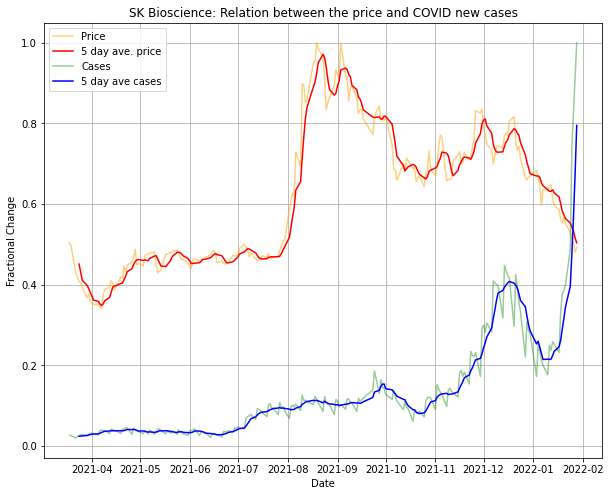

<Figure size 432x288 with 0 Axes>

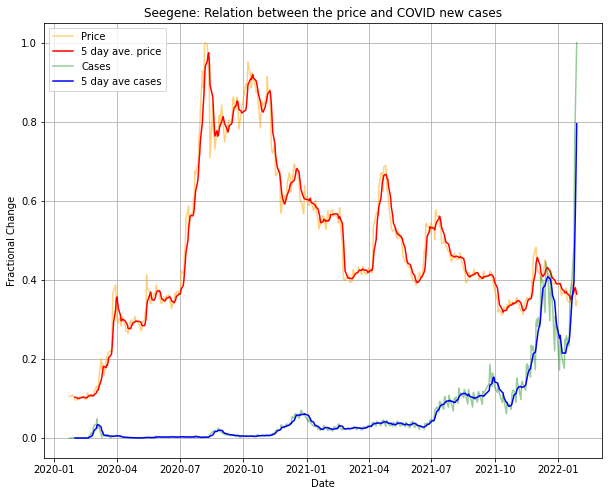

<Figure size 432x288 with 0 Axes>

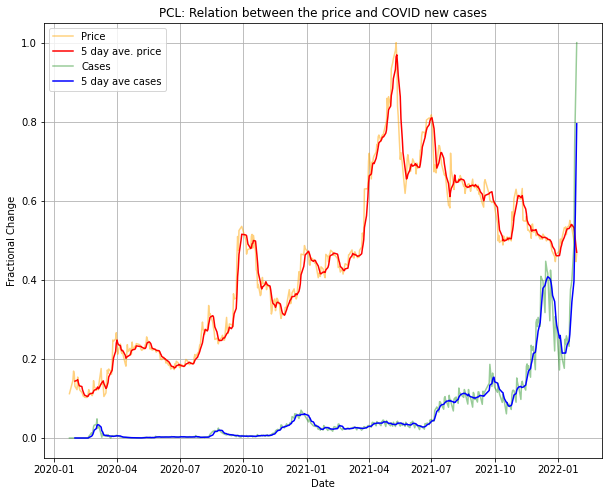

<Figure size 432x288 with 0 Axes>

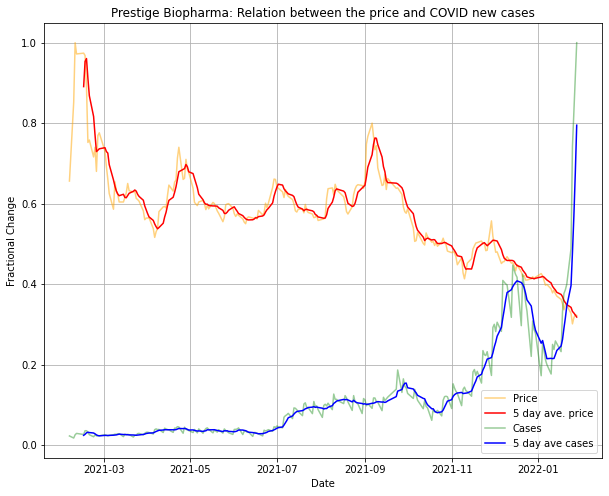

<Figure size 432x288 with 0 Axes>

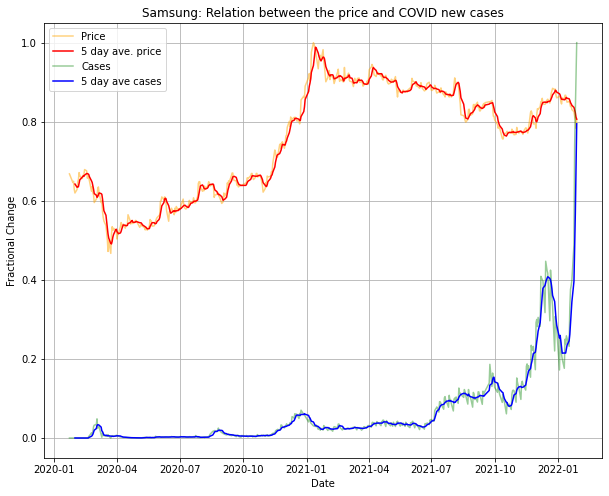

<Figure size 432x288 with 0 Axes>

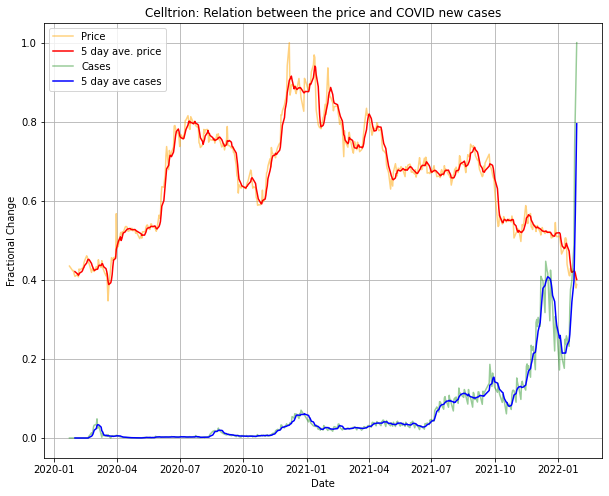

<Figure size 432x288 with 0 Axes>

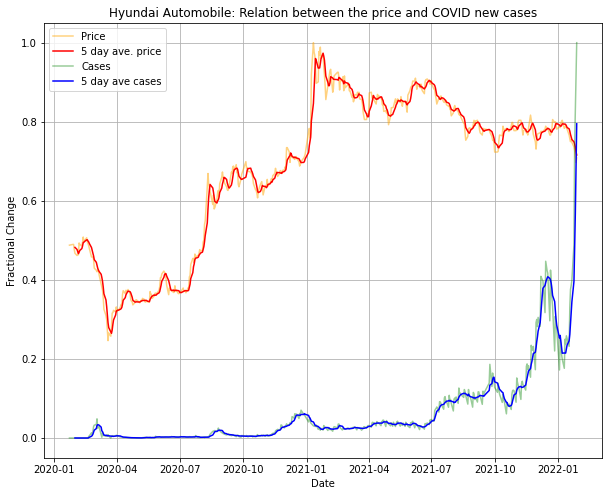

<Figure size 432x288 with 0 Axes>

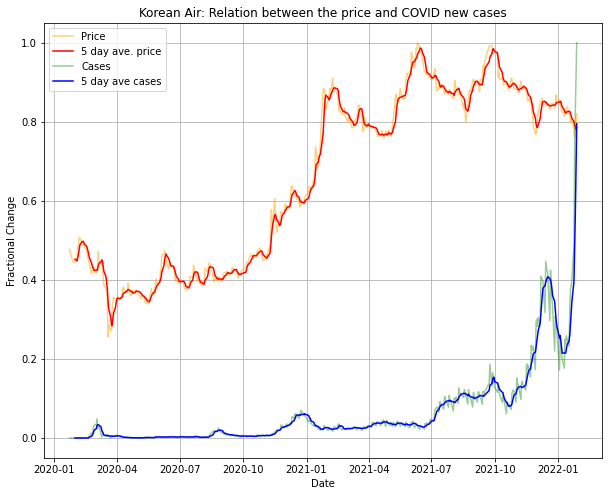

<Figure size 432x288 with 0 Axes>

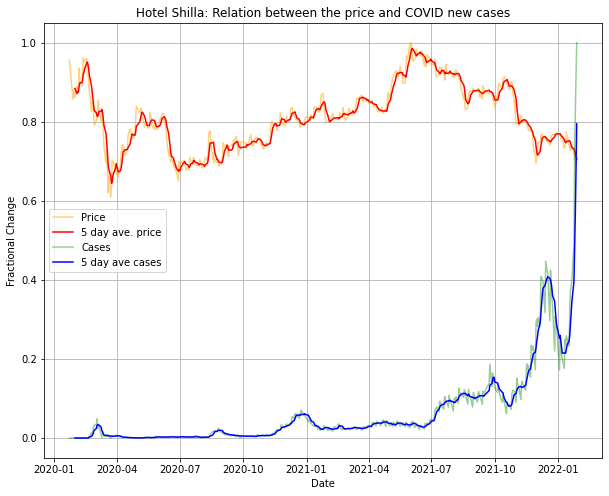

<Figure size 432x288 with 0 Axes>

In [19]:
print('Displaying the data from ', short_df.index[0], 'to ', end_date, '\n')

for key0 in Company_names:

  #Join stock and COVID dataframes
  full_df = pd.concat([stock_list[key0], short_df], axis=1).dropna()
  plt.figure(figsize = (10,8))

  plt.plot(full_df[Company_names[key0]]/full_df[Company_names[key0]].max(), color = 'orange', label ='Price', alpha=0.5)
  plt.plot( (full_df[Company_names[key0]]/full_df[Company_names[key0]].max() ).rolling(5).mean(), color = 'red', label ='5 day ave. price')
  plt.plot(full_df['new_cases']/full_df['new_cases'].max(), color = 'green', label='Cases', alpha=0.4)
  plt.plot((full_df['new_cases']/full_df['new_cases'].max()).rolling(5).mean(), color = 'blue', label='5 day ave cases')


  plt.xlabel('Date')
  plt.ylabel('Fractional Change')
  plt.title(Company_names[key0] +': Relation between the price and COVID new cases')
  plt.legend()
  plt.grid(True)

  plt.show()  # show the plot

  plt.clf()  # clear the plot space


In [8]:
#For US new cases

my_file = '/content/owid-covid-data.csv'
short_df = pd.read_csv(my_file)
#print(short_df.columns)

short_df = short_df[short_df['location']=='United States']


columns=['date', 'new_cases']
short_df= short_df[columns]

# sort the short sell data
short_df['Date'] = pd.to_datetime(short_df['date'])
short_df = short_df.pivot_table(index='Date', values=['new_cases'])
#short_df = short_df.sort_index()

#Set the beginning date for the analysis
print(short_df.index[0])
start_date = short_df.index[0]
end_date = short_df.index[-1] 
print('Displaying the data from ', start_date, 'to ', end_date, '\n')

print(short_df.head())
print(short_df.tail())

2020-01-23 00:00:00
Displaying the data from  2020-01-23 00:00:00 to  2022-01-29 00:00:00 

            new_cases
Date                 
2020-01-23        0.0
2020-01-24        1.0
2020-01-25        0.0
2020-01-26        3.0
2020-01-27        0.0
            new_cases
Date                 
2022-01-25   549956.0
2022-01-26   647209.0
2022-01-27   443607.0
2022-01-28   642857.0
2022-01-29   169002.0


In [ ]:
#For US Companies

US_Companies= {'Bio-Rad Laboratories, Inc.':'BIO', 'Novavax, Inc.':'NVAX', 'Abbott Laboratories':'ABT', 'Quidel Corporation':'QDEL', \
               'Moderna, Inc.' : 'MRNA', 'Pfizer Inc. ':'PFE'}

US_stock_list = {}
for name, symbol in US_Companies.items():

# Load the stock market data from start_date to today
  
  stock_data = fdr.DataReader(symbol, start_date, end_date)

#Data transform using the closing price
  stock_data = stock_data.pivot_table(index='Date', values=['Close'])

  stock_data.columns = [name]

  #stock_data['Name'] = name

  US_stock_list[name] = stock_data
  #stock_data.info()

In [ ]:
for key0, symbol in US_Companies.items():

  #Join stock and COVID dataframes
  full_df = pd.concat([US_stock_list[key0], short_df], axis=1).dropna()
  plt.figure(figsize = (10,8))

  plt.plot(full_df[key0]/full_df[key0].max(), color = 'orange', label ='Price')
  plt.plot(full_df['new_cases']/full_df['new_cases'].max(), color = 'green', label='Balance')


  plt.xlabel('Date')
  plt.ylabel('Fractional Change')
  plt.title(key0 +': Relation between the price and COVID new cases')
  plt.legend()
  plt.grid(True)

  plt.show()  # show the plot

  plt.clf()  # clear the plot space


In [ ]:
for key0, symbol in US_Companies.items():

  #Join stock and COVID dataframes
  full_df = pd.concat([US_stock_list[key0], short_df], axis=1)['2021-10-01':].dropna()
  plt.figure(figsize = (10,8))

  ax = plt.plot(full_df[key0]/full_df[key0].max(), color = 'orange', label ='Price')
  plt.plot(full_df['new_cases']/full_df['new_cases'].max(), color = 'green', label='Balance')

  #ax.axvspan('2021-12-15', alpha=0.3, color='red') 

  plt.xlabel('Date')
  plt.ylabel('Fractional Change')
  plt.title(key0 +': Relation between the price and COVID new cases')
  plt.legend()
  plt.grid(True)

  plt.show()  # show the plot

  plt.clf()  # clear the plot space